In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

!pip install pandasql
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandasql as ps
from sqlite3 import connect
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

conn=connect(':memory:')

#SET PATHS
main="/content/gdrive/MyDrive/FIMA SUMMER 2023/RISK MANAGEMENT/FAMA FRENCH FACTORS/main_"
raw= main + '_raw/'
aux= raw + 'Cake Shop Realtime Fundamentals as of June 23, 2023/'
clean= main + '_clean/'

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=cb597b78f2b8347cac309965ea63b93c48c65e417eec655b75b93c70617e14f0
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
Mounted at /content/gdrive


In [ ]:
#SET PATHS
main="/content/gdrive/MyDrive/FIMA SUMMER 2023/RISK MANAGEMENT/FAMA FRENCH FACTORS/_main/"
raw= main + '_raw/'
aux= raw + 'Cake Shop Realtime Fundamentals as of June 23, 2023/'
clean= main + '_clean/'

In [ ]:
main_stocks_df=pd.read_csv(clean + "FF3 Dataload 07_17.csv")

# Construct Size Value Portfolios

In [ ]:
#Create master copy of main stocks df and remove negative bm_values

main_stocks_df_master=main_stocks_df.copy()
main_stocks_df = main_stocks_df[main_stocks_df['bm_ratio'] >= 0]


In [ ]:
from scipy.stats.mstats import winsorize
#winsorise returns at the 99.9% percentile
main_stocks_df['ret'] = winsorize(main_stocks_df['ret'], limits=[0.000, 0.001])

In [ ]:
#Create portfolios based on size and value
valueWeightRet = main_stocks_df.groupby(['date', 'size_portfolio', 'value_portfolio']).apply(
    lambda x: np.average(pd.to_numeric(x['ret']), weights=pd.to_numeric(x['mkt_cap']))).reset_index()



valueWeightRet

,date,size_portfolio,value_portfolio,0
0,2019-06-03,B,H,1.942946
1,2019-06-03,B,L,-1.842236
2,2019-06-03,B,M,0.378998
3,2019-06-03,S,H,1.061874
4,2019-06-03,S,L,-0.334302
...,...,...,...,...
6133,2023-06-23,B,L,-0.763815
6134,2023-06-23,B,M,-0.582873
6135,2023-06-23,S,H,-1.358928
6136,2023-06-23,S,L,-1.753329


In [ ]:
valueWeightRet_pivot = valueWeightRet.pivot_table(index=['date'], columns=['size_portfolio', 'value_portfolio'], values=0)
valueWeightRet_pivot.reset_index(inplace=True)
# iterate over the columns and join them with a '/'
valueWeightRet_pivot.columns = ['/'.join(col) for col in valueWeightRet_pivot.columns.values]
p=valueWeightRet_pivot
p

,date/,B/H,B/L,B/M,S/H,S/L,S/M
0,2019-06-03,1.942946,-1.842236,0.378998,1.061874,-0.334302,0.713756
1,2019-06-04,2.590159,2.318461,2.162649,2.930481,2.816069,3.072941
2,2019-06-05,-0.337160,0.963575,0.561098,-0.944979,0.252995,-0.159057
3,2019-06-06,1.109399,0.703466,0.402494,-0.376919,-0.773566,-0.271791
4,2019-06-07,0.466004,1.825441,0.952374,1.154855,1.413932,1.037449
...,...,...,...,...,...,...,...
1018,2023-06-16,-0.053254,-0.542585,-0.355106,-0.362397,-0.470054,-0.806413
1019,2023-06-20,-1.622232,-0.224319,-0.734602,-0.051952,-0.405841,-0.260739
1020,2023-06-21,-1.398117,-0.796012,-0.175353,0.336743,-0.317875,-0.265617
1021,2023-06-22,-0.486996,1.160452,-0.130844,-0.955388,-0.697611,-0.750209


In [ ]:
#Construct Factors from Portfolios
p['smb__hml'] = 1/3*(p['S/H']+ p['S/M']+p['S/L']) - 1/3*(p['B/H']+p['B/L']+p['B/M'])
p['hml']=(0.5*(p['S/H']+p['B/H']))-(0.5*(p['S/L']+p['B/L']))

In [ ]:
size_value=p

# Construct Size Investment Portfolios

In [ ]:

main_stocks_df= main_stocks_df_master

In [ ]:
main_stocks_df = main_stocks_df.dropna(subset=['mkt_cap', 'inv'])

main_stocks_df['ret'] = winsorize(main_stocks_df['ret'], limits=[0.000, 0.01])

valueWeightRet = main_stocks_df.groupby(['date', 'size_portfolio', 'inv_portfolio']).apply(
    lambda x: np.average(pd.to_numeric(x['ret']), weights=pd.to_numeric(x['mkt_cap']))).reset_index()

valueWeightRet

,date,size_portfolio,inv_portfolio,0
0,2019-06-03,B,H,-2.981815
1,2019-06-03,B,L,0.535529
2,2019-06-03,B,M,-0.337958
3,2019-06-03,S,H,0.230640
4,2019-06-03,S,L,0.629174
...,...,...,...,...
6133,2023-06-23,B,L,-0.634676
6134,2023-06-23,B,M,-0.688577
6135,2023-06-23,S,H,-1.554929
6136,2023-06-23,S,L,-1.635406


In [ ]:
valueWeightRet_pivot = valueWeightRet.pivot_table(index=['date'], columns=['size_portfolio', 'inv_portfolio'], values=0)
valueWeightRet_pivot.reset_index(inplace=True)
# iterate over the columns and join them with a '/'
valueWeightRet_pivot.columns = ['/'.join(col) for col in valueWeightRet_pivot.columns.values]
p=valueWeightRet_pivot
p

,date/,B/H,B/L,B/M,S/H,S/L,S/M
0,2019-06-03,-2.981815,0.535529,-0.337958,0.230640,0.629174,0.736051
1,2019-06-04,2.335613,2.272552,2.317438,2.889542,2.963587,3.046002
2,2019-06-05,0.459436,0.853923,1.015395,-0.208494,-0.328458,-0.237865
3,2019-06-06,0.491952,0.714148,0.837732,-0.489420,-0.393753,-0.444933
4,2019-06-07,1.887805,1.274365,1.338241,1.519726,0.978241,0.803172
...,...,...,...,...,...,...,...
1018,2023-06-16,-0.549660,-0.142589,-0.605393,-0.851681,-0.543448,-0.394789
1019,2023-06-20,0.334289,-0.603880,-0.667067,-0.150698,-0.225952,-0.485303
1020,2023-06-21,-1.105482,-0.359416,-0.592036,0.106796,-0.508526,-0.106368
1021,2023-06-22,0.982415,0.651241,0.811344,-0.782960,-0.663413,-1.025742


In [ ]:
p['cma']=0.5*(p['S/L']+p['B/L'])-0.5*(p['S/H']+p['B/H'])
p['smb__inv']=1/3*(p['S/H']+ p['S/M']+p['S/L']) - 1/3*(p['B/H']+p['B/L']+p['B/M'])

In [ ]:
size_inv=p[['date/', 'cma', 'smb__inv']]

# Construct Size OP Portfolios

In [ ]:
main_stocks_df=main_stocks_df_master

In [ ]:
from scipy.stats.mstats import winsorize

main_stocks_df['ret'] = winsorize(main_stocks_df['ret'], limits=[0.000, 0.001])

valueWeightRet = main_stocks_df.groupby(['date', 'size_portfolio', 'op_portfolio']).apply(
    lambda x: np.average(pd.to_numeric(x['ret']), weights=pd.to_numeric(x['mkt_cap']))).reset_index()

valueWeightRet

,date,size_portfolio,op_portfolio,0
0,2019-06-03,B,H,-1.189769
1,2019-06-03,B,L,0.755023
2,2019-06-03,B,M,-1.350328
3,2019-06-03,S,H,0.635405
4,2019-06-03,S,L,0.311689
...,...,...,...,...
6133,2023-06-23,B,L,-0.758870
6134,2023-06-23,B,M,-0.848804
6135,2023-06-23,S,H,-1.721629
6136,2023-06-23,S,L,-1.543064


In [ ]:
valueWeightRet_pivot = valueWeightRet.pivot_table(index=['date'], columns=['size_portfolio', 'op_portfolio'], values=0)
valueWeightRet_pivot.reset_index(inplace=True)
# iterate over the columns and join them with a '/'
valueWeightRet_pivot.columns = ['/'.join(col) for col in valueWeightRet_pivot.columns.values]
p=valueWeightRet_pivot
p

,date/,B/H,B/L,B/M,S/H,S/L,S/M
0,2019-06-03,-1.189769,0.755023,-1.350328,0.635405,0.311689,0.607297
1,2019-06-04,2.495091,2.101650,2.093717,3.183396,2.646787,3.175093
2,2019-06-05,0.989802,1.070167,0.316294,-0.462516,-0.113089,-0.267462
3,2019-06-06,0.782653,0.582838,0.544678,-0.539976,-0.633264,-0.216664
4,2019-06-07,1.764068,0.922872,1.328513,1.166920,1.266771,1.100425
...,...,...,...,...,...,...,...
1018,2023-06-16,-0.693833,-0.565511,0.059437,-0.527626,-0.810370,-0.371449
1019,2023-06-20,-0.445725,-0.907272,-0.076008,-0.477744,0.050941,-0.399791
1020,2023-06-21,-0.625429,-0.688864,-0.799177,0.184175,-0.547769,0.215975
1021,2023-06-22,1.201576,-0.404719,0.223231,-0.703159,-1.007852,-0.622681


In [ ]:
p['rmw']=0.5*(p['S/H']+p['B/H'])-0.5*(p['S/L']+p['B/L'])
p['smb__op']=1/3*(p['S/H']+ p['S/M']+p['S/L']) - 1/3*(p['B/H']+p['B/L']+p['B/M'])

In [ ]:
size_op=p[['date/', 'rmw', 'smb__op']]

# Merge Together Factors

In [ ]:
factors= size_value.merge(size_inv, on='date/', how='outer')
factors= factors.merge(size_op, on='date/', how='outer')
factors

,date/,B/H,B/L,B/M,S/H,S/L,S/M,smb__hml,hml,cma,smb__inv,rmw,smb__op
0,2019-06-03,1.942946,-1.842236,0.378998,1.061874,-0.334302,0.713756,0.320540,2.590679,1.957939,1.460037,-0.810538,1.113155
1,2019-06-04,2.590159,2.318461,2.162649,2.930481,2.816069,3.072941,0.582741,0.193055,0.005492,0.657843,0.465025,0.771606
2,2019-06-05,-0.337160,0.963575,0.561098,-0.944979,0.252995,-0.159057,-0.679518,-1.249355,0.137262,-1.034524,-0.214896,-1.073110
3,2019-06-06,1.109399,0.703466,0.402494,-0.376919,-0.773566,-0.271791,-1.212545,0.401290,0.158932,-1.123979,0.146551,-1.100024
4,2019-06-07,0.466004,1.825441,0.952374,1.154855,1.413932,1.037449,0.120805,-0.809257,-0.577463,-0.399757,0.370673,-0.160446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2023-06-16,-0.053254,-0.542585,-0.355106,-0.362397,-0.470054,-0.806413,-0.229306,0.298494,0.357653,-0.164092,0.077211,-0.169846
1019,2023-06-20,-1.622232,-0.224319,-0.734602,-0.051952,-0.405841,-0.260739,0.620873,-0.522012,-0.506711,0.024901,-0.033569,0.200804
1020,2023-06-21,-1.398117,-0.796012,-0.175353,0.336743,-0.317875,-0.265617,0.707578,0.026256,0.065372,0.516279,0.397690,0.655284
1021,2023-06-22,-0.486996,1.160452,-0.130844,-0.955388,-0.697611,-0.750209,-0.981940,-0.952612,-0.105813,-1.639038,0.955494,-1.117927


Calculate SMB Factor as average of 3 SMB Factors

In [ ]:
factors['smb']=1/3*(factors['smb__hml']+factors['smb__inv']+factors['smb__op'])

Construct Market Factor

In [ ]:
weighted_dailyRet=main_stocks_df.groupby('date').apply(lambda x: np.average(pd.to_numeric(x.ret), weights=pd.to_numeric(x.mkt_cap)))
mkt = pd.DataFrame(weighted_dailyRet)
mkt.reset_index(inplace=True)
mkt['date']=pd.to_datetime(mkt['date'])
mkt.rename(columns={0:'mkt'}, inplace=True)

In [ ]:
mkt

,date,mkt
0,2019-06-03,-0.942777
1,2019-06-04,2.343123
2,2019-06-05,0.719568
3,2019-06-06,0.623550
4,2019-06-07,1.501256
...,...,...
1018,2023-06-16,-0.488831
1019,2023-06-20,-0.376859
1020,2023-06-21,-0.652179
1021,2023-06-22,0.755828


In [ ]:
factors

,date/,B/H,B/L,B/M,S/H,S/L,S/M,smb__hml,hml,cma,smb__inv,rmw,smb__op,smb
0,2019-06-03,1.942946,-1.842236,0.378998,1.061874,-0.334302,0.713756,0.320540,2.590679,1.957939,1.460037,-0.810538,1.113155,0.964577
1,2019-06-04,2.590159,2.318461,2.162649,2.930481,2.816069,3.072941,0.582741,0.193055,0.005492,0.657843,0.465025,0.771606,0.670730
2,2019-06-05,-0.337160,0.963575,0.561098,-0.944979,0.252995,-0.159057,-0.679518,-1.249355,0.137262,-1.034524,-0.214896,-1.073110,-0.929050
3,2019-06-06,1.109399,0.703466,0.402494,-0.376919,-0.773566,-0.271791,-1.212545,0.401290,0.158932,-1.123979,0.146551,-1.100024,-1.145516
4,2019-06-07,0.466004,1.825441,0.952374,1.154855,1.413932,1.037449,0.120805,-0.809257,-0.577463,-0.399757,0.370673,-0.160446,-0.146466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2023-06-16,-0.053254,-0.542585,-0.355106,-0.362397,-0.470054,-0.806413,-0.229306,0.298494,0.357653,-0.164092,0.077211,-0.169846,-0.187748
1019,2023-06-20,-1.622232,-0.224319,-0.734602,-0.051952,-0.405841,-0.260739,0.620873,-0.522012,-0.506711,0.024901,-0.033569,0.200804,0.282193
1020,2023-06-21,-1.398117,-0.796012,-0.175353,0.336743,-0.317875,-0.265617,0.707578,0.026256,0.065372,0.516279,0.397690,0.655284,0.626380
1021,2023-06-22,-0.486996,1.160452,-0.130844,-0.955388,-0.697611,-0.750209,-0.981940,-0.952612,-0.105813,-1.639038,0.955494,-1.117927,-1.246301


In [ ]:
factors.rename(columns={'date/':'date'}, inplace=True)
factors['date']=pd.to_datetime(factors['date'])
factors = factors.merge(mkt, on='date', how='outer')
factors=factors[['date', 'mkt', 'smb', 'hml', 'cma', 'rmw']]

In [ ]:
factors

,date,mkt,smb,hml,cma,rmw
0,2019-06-03,-0.942777,0.964577,2.590679,1.957939,-0.810538
1,2019-06-04,2.343123,0.670730,0.193055,0.005492,0.465025
2,2019-06-05,0.719568,-0.929050,-1.249355,0.137262,-0.214896
3,2019-06-06,0.623550,-1.145516,0.401290,0.158932,0.146551
4,2019-06-07,1.501256,-0.146466,-0.809257,-0.577463,0.370673
...,...,...,...,...,...,...
1018,2023-06-16,-0.488831,-0.187748,0.298494,0.357653,0.077211
1019,2023-06-20,-0.376859,0.282193,-0.522012,-0.506711,-0.033569
1020,2023-06-21,-0.652179,0.626380,0.026256,0.065372,0.397690
1021,2023-06-22,0.755828,-1.246301,-0.952612,-0.105813,0.955494


# Import Fama French Data For Comparison

In [ ]:
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
datasets = get_available_datasets()



df_3_factor=[dataset for dataset in datasets if 'Research' in dataset and 'Factor' in dataset]
df_3_factor
ff=web.DataReader(df_3_factor[4],'famafrench',start='2018-01-01',end='2022-12-01')[0]
ff.reset_index(inplace=True)
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2018-01-02,0.85,0.31,-0.21,-0.50,0.31,0.006
1,2018-01-03,0.59,-0.47,-0.19,-0.70,-0.06,0.006
2,2018-01-04,0.42,-0.22,0.25,-0.01,0.31,0.006
3,2018-01-05,0.66,-0.37,-0.25,0.37,-0.37,0.006
4,2018-01-08,0.19,-0.19,0.04,-0.07,0.01,0.006
...,...,...,...,...,...,...,...
1234,2022-11-25,-0.02,0.27,0.43,-0.17,0.14,0.014
1235,2022-11-28,-1.55,-0.47,-0.21,0.31,0.32,0.014
1236,2022-11-29,-0.18,0.35,1.03,0.19,0.47,0.014
1237,2022-11-30,3.12,-0.14,-2.07,-0.78,-1.42,0.014


In [ ]:
ff['Date']=pd.to_datetime(ff['Date'])
checker= factors.reset_index().merge(ff, left_on='date', right_on='Date', how='left')
checker

,index,date,mkt,smb,hml,cma,rmw,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,0,2019-06-03,-0.942777,0.964577,2.590679,1.957939,-0.810538,2019-06-03,-0.40,0.58,1.65,0.28,1.39,0.009
1,1,2019-06-04,2.343123,0.670730,0.193055,0.005492,0.465025,2019-06-04,2.33,0.49,-0.02,0.29,-0.47,0.009
2,2,2019-06-05,0.719568,-0.929050,-1.249355,0.137262,-0.214896,2019-06-05,0.70,-1.06,-0.97,0.06,-0.20,0.009
3,3,2019-06-06,0.623550,-1.145516,0.401290,0.158932,0.146551,2019-06-06,0.55,-1.08,0.01,0.06,-0.07,0.009
4,4,2019-06-07,1.501256,-0.146466,-0.809257,-0.577463,0.370673,2019-06-07,1.04,-0.14,-1.20,0.35,-0.65,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,1018,2023-06-16,-0.488831,-0.187748,0.298494,0.357653,0.077211,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1019,1019,2023-06-20,-0.376859,0.282193,-0.522012,-0.506711,-0.033569,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1020,1020,2023-06-21,-0.652179,0.626380,0.026256,0.065372,0.397690,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1021,1021,2023-06-22,0.755828,-1.246301,-0.952612,-0.105813,0.955494,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
checker.corr(method='pearson').round(2)


<ipython-input-58-665523e69cbf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  checker.corr(method='pearson').round(2)


,index,mkt,smb,hml,cma,rmw,Mkt-RF,SMB,HML,RMW,CMA,RF
index,1.00,-0.02,-0.01,0.03,0.01,0.01,-0.03,0.01,0.05,0.03,0.06,-0.11
mkt,-0.02,1.00,0.27,-0.28,-0.47,-0.16,0.93,0.15,-0.16,-0.18,-0.36,-0.02
smb,-0.01,0.27,1.00,0.27,-0.11,-0.39,0.29,0.95,0.27,-0.30,-0.05,-0.03
hml,0.03,-0.28,0.27,1.00,0.72,0.35,-0.10,0.35,0.90,0.39,0.66,-0.02
cma,0.01,-0.47,-0.11,0.72,1.00,0.41,-0.28,0.01,0.65,0.44,0.84,0.02
rmw,0.01,-0.16,-0.39,0.35,0.41,1.00,-0.09,-0.30,0.45,0.87,0.40,-0.02
Mkt-RF,-0.03,0.93,0.29,-0.10,-0.28,-0.09,1.00,0.20,-0.03,-0.12,-0.29,-0.02
SMB,0.01,0.15,0.95,0.35,0.01,-0.30,0.20,1.00,0.34,-0.22,0.02,-0.04
HML,0.05,-0.16,0.27,0.90,0.65,0.45,-0.03,0.34,1.00,0.46,0.64,-0.03
RMW,0.03,-0.18,-0.30,0.39,0.44,0.87,-0.12,-0.22,0.46,1.00,0.41,-0.01


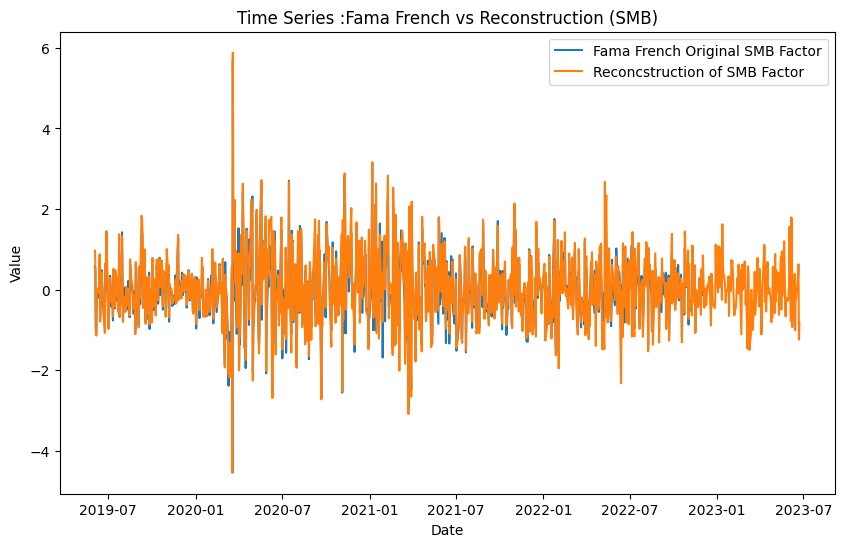

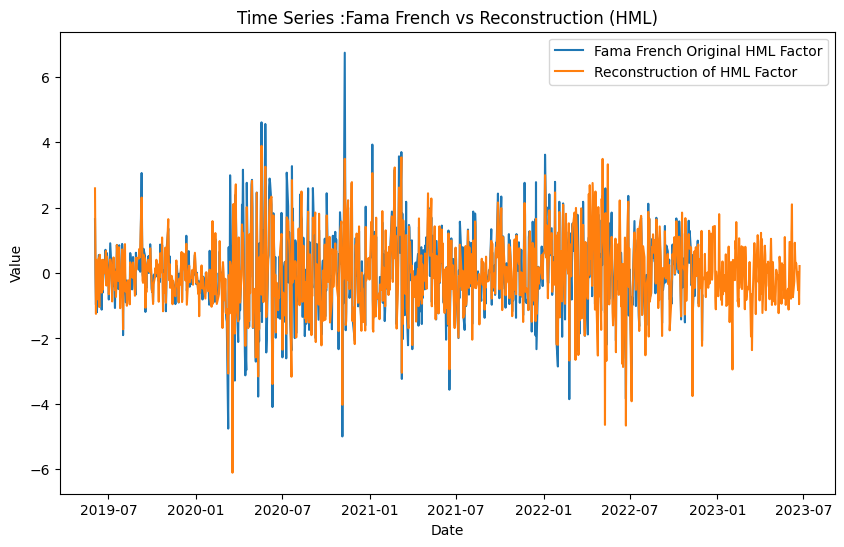

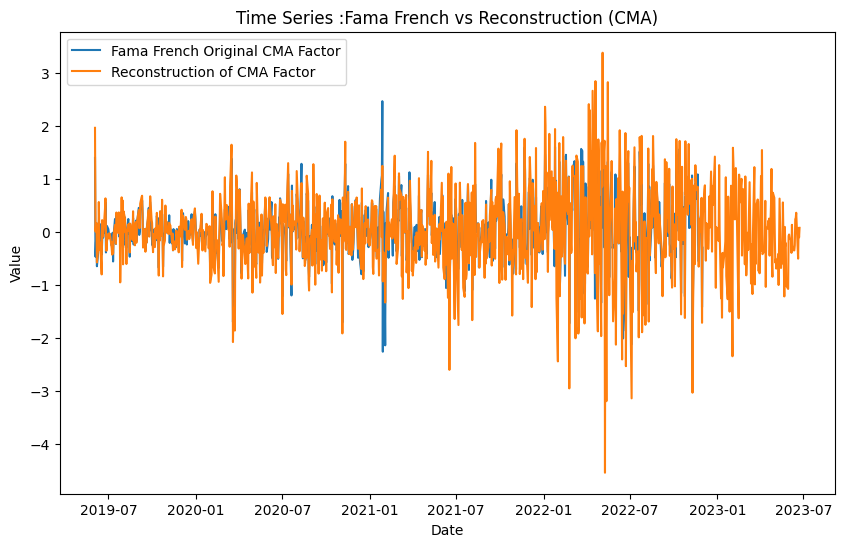

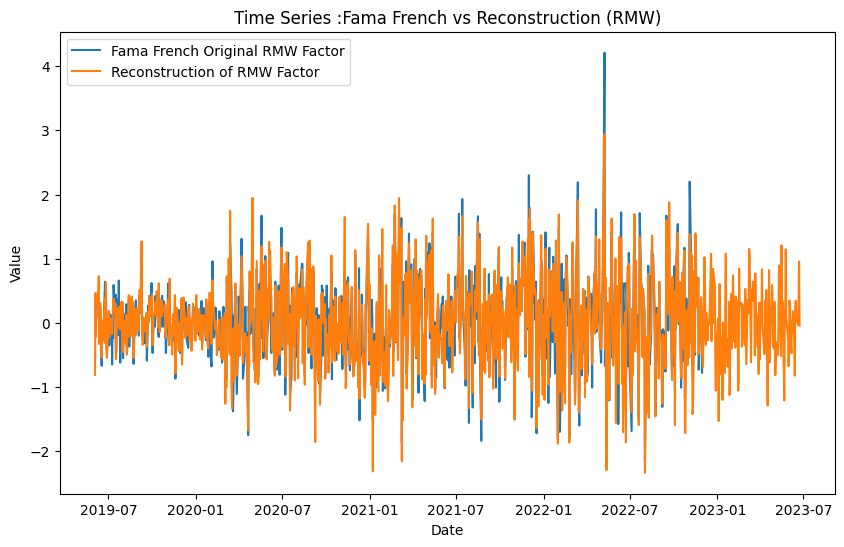

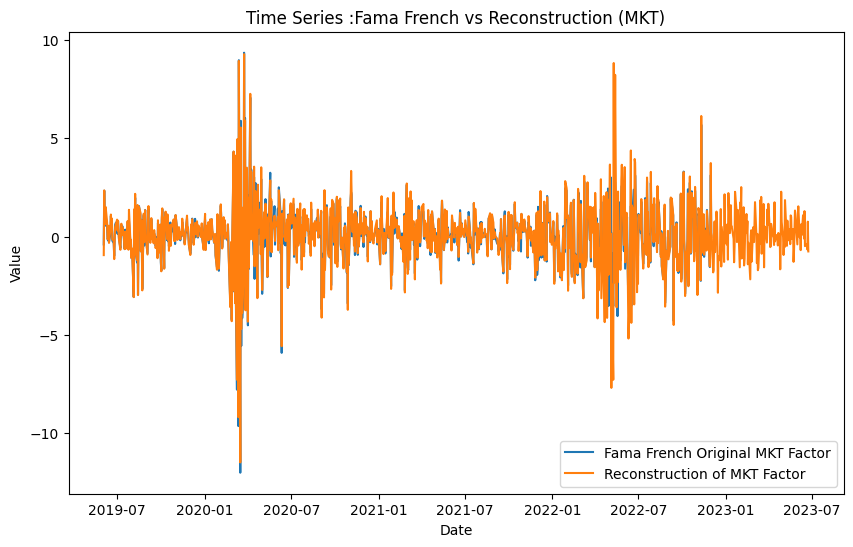

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


checker['date'] = pd.to_datetime(checker['date'])

# Plotting SMB vs smb
plt.figure(figsize=(10, 6))
plt.plot(checker['date'], checker['SMB'], label='Fama French Original SMB Factor')
plt.plot(checker['date'], checker['smb'], label='Reconcstruction of SMB Factor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series :Fama French vs Reconstruction (SMB)')
plt.legend()
plt.show()

# Plotting HML vs hml
plt.figure(figsize=(10, 6))
plt.plot(checker['date'], checker['HML'], label='Fama French Original HML Factor')
plt.plot(checker['date'], checker['hml'], label='Reconstruction of HML Factor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series :Fama French vs Reconstruction (HML)')
plt.legend()
plt.show()


# Plotting HML vs hml
plt.figure(figsize=(10, 6))
plt.plot(checker['date'], checker['CMA'], label='Fama French Original CMA Factor')
plt.plot(checker['date'], checker['cma'], label='Reconstruction of CMA Factor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series :Fama French vs Reconstruction (CMA)')
plt.legend()
plt.show()

# Plotting HML vs hml
plt.figure(figsize=(10, 6))
plt.plot(checker['date'], checker['RMW'], label='Fama French Original RMW Factor')
plt.plot(checker['date'], checker['rmw'], label='Reconstruction of RMW Factor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series :Fama French vs Reconstruction (RMW)')
plt.legend()
plt.show()

# Plotting HML vs hml
plt.figure(figsize=(10, 6))
plt.plot(checker['date'], checker['Mkt-RF'], label='Fama French Original MKT Factor')
plt.plot(checker['date'], checker['mkt'], label='Reconstruction of MKT Factor')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series :Fama French vs Reconstruction (MKT)')
plt.legend()
plt.show()


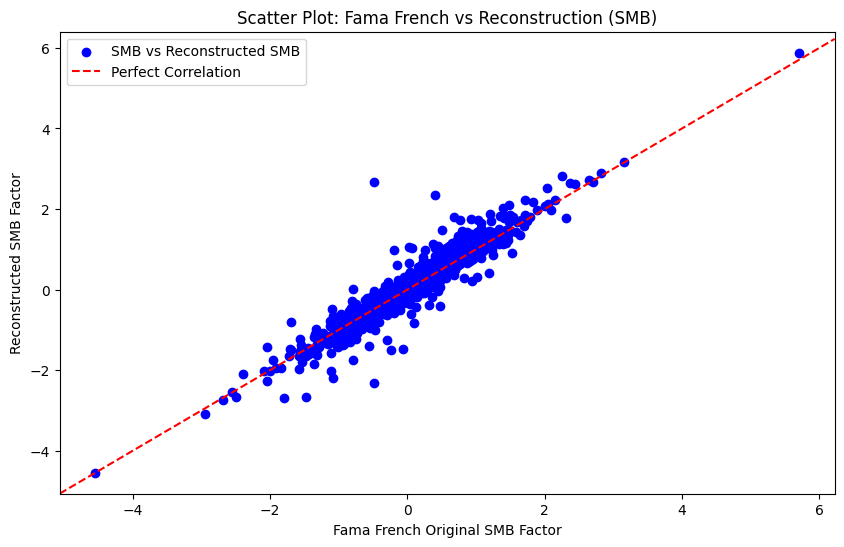

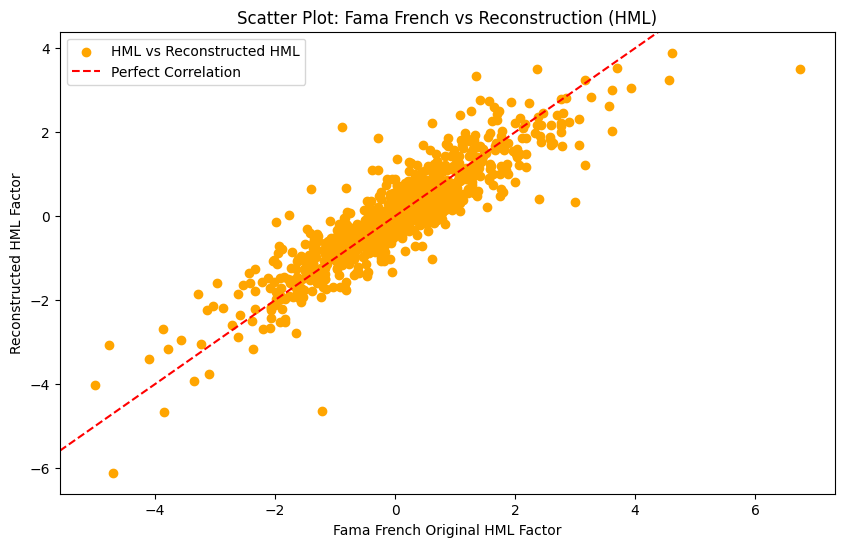

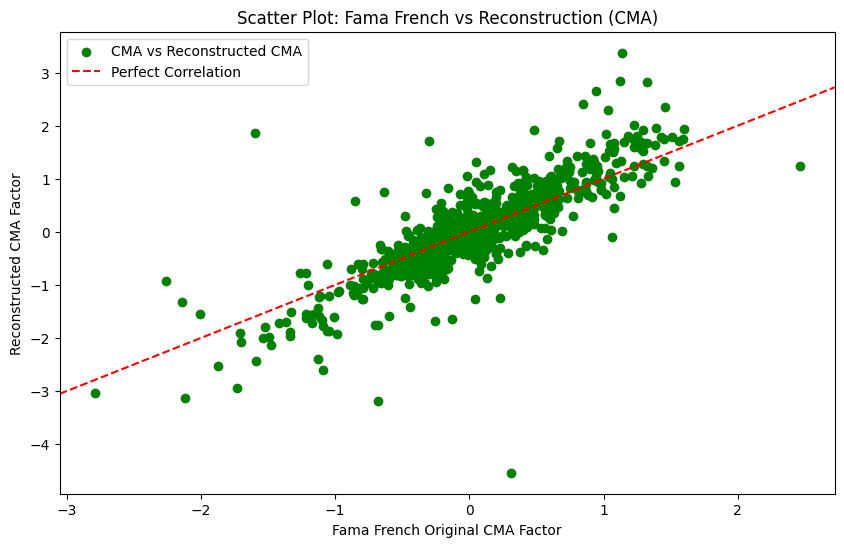

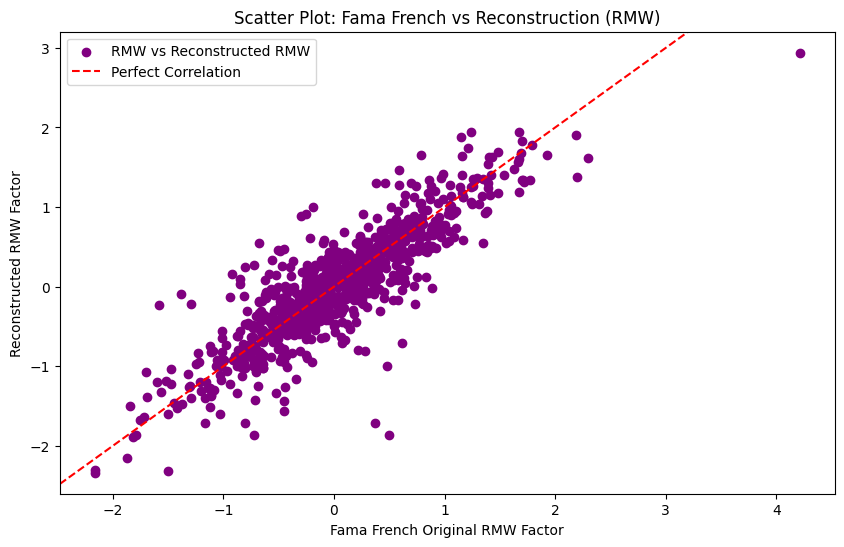

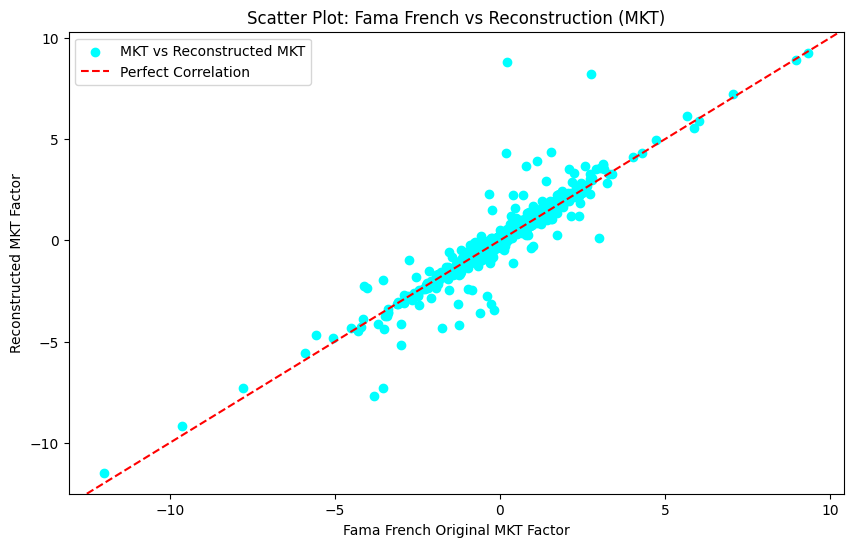

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

checker['date'] = pd.to_datetime(checker['date'])

# Function to calculate Pearson correlation coefficient
def pearson_corr(x, y):
    return x.corr(y)

# Plotting SMB vs smb
plt.figure(figsize=(10, 6))
plt.scatter(checker['SMB'], checker['smb'], label='SMB vs Reconstructed SMB', color='blue')
plt.xlabel('Fama French Original SMB Factor')
plt.ylabel('Reconstructed SMB Factor')
plt.title('Scatter Plot: Fama French vs Reconstruction (SMB)')
plt.axline([0, 0], slope=1, linestyle='--', color='red', label='Perfect Correlation')
plt.legend()
plt.show()

# Plotting HML vs hml
plt.figure(figsize=(10, 6))
plt.scatter(checker['HML'], checker['hml'], label='HML vs Reconstructed HML', color='orange')
plt.xlabel('Fama French Original HML Factor')
plt.ylabel('Reconstructed HML Factor')
plt.title('Scatter Plot: Fama French vs Reconstruction (HML)')
plt.axline([0, 0], slope=1, linestyle='--', color='red', label='Perfect Correlation')
plt.legend()
plt.show()

# Plotting CMA vs cma
plt.figure(figsize=(10, 6))
plt.scatter(checker['CMA'], checker['cma'], label='CMA vs Reconstructed CMA', color='green')
plt.xlabel('Fama French Original CMA Factor')
plt.ylabel('Reconstructed CMA Factor')
plt.title('Scatter Plot: Fama French vs Reconstruction (CMA)')
plt.axline([0, 0], slope=1, linestyle='--', color='red', label='Perfect Correlation')
plt.legend()
plt.show()

# Plotting RMW vs rmw
plt.figure(figsize=(10, 6))
plt.scatter(checker['RMW'], checker['rmw'], label='RMW vs Reconstructed RMW', color='purple')
plt.xlabel('Fama French Original RMW Factor')
plt.ylabel('Reconstructed RMW Factor')
plt.title('Scatter Plot: Fama French vs Reconstruction (RMW)')
plt.axline([0, 0], slope=1, linestyle='--', color='red', label='Perfect Correlation')
plt.legend()
plt.show()

# Plotting Mkt-RF vs mkt
plt.figure(figsize=(10, 6))
plt.scatter(checker['Mkt-RF'], checker['mkt'], label='MKT vs Reconstructed MKT', color='cyan')
plt.xlabel('Fama French Original MKT Factor')
plt.ylabel('Reconstructed MKT Factor')
plt.title('Scatter Plot: Fama French vs Reconstruction (MKT)')
plt.axline([0, 0], slope=1, linestyle='--', color='red', label='Perfect Correlation')
plt.legend()
plt.show()
